In [16]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
path_to_csv = r'../data/user_behavior.csv' # path to dataset

In [18]:
df = pd.read_csv(path_to_csv) # loading dataset into pandas dataframe

In [19]:
# analyzing dataset and cleaning

df.shape                   # Check shape of the dataset
df.info()                  # Data types and non-null counts
df.isnull().sum()          # Nulls per column
df[df.isnull().any(axis=1)]  # See rows with any missing values
df.duplicated().sum()      # Number of duplicate rows
df = df.drop_duplicates()  # Remove duplicates
df['churned'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 1000 non-null   int64  
 1   account_age_days        1000 non-null   int64  
 2   total_hours_watched     1000 non-null   int64  
 3   num_genres_watched      1000 non-null   int64  
 4   avg_watch_time_per_day  1000 non-null   float64
 5   num_devices             1000 non-null   int64  
 6   support_tickets_opened  1000 non-null   int64  
 7   churned                 1000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


churned
0    0.503
1    0.497
Name: proportion, dtype: float64

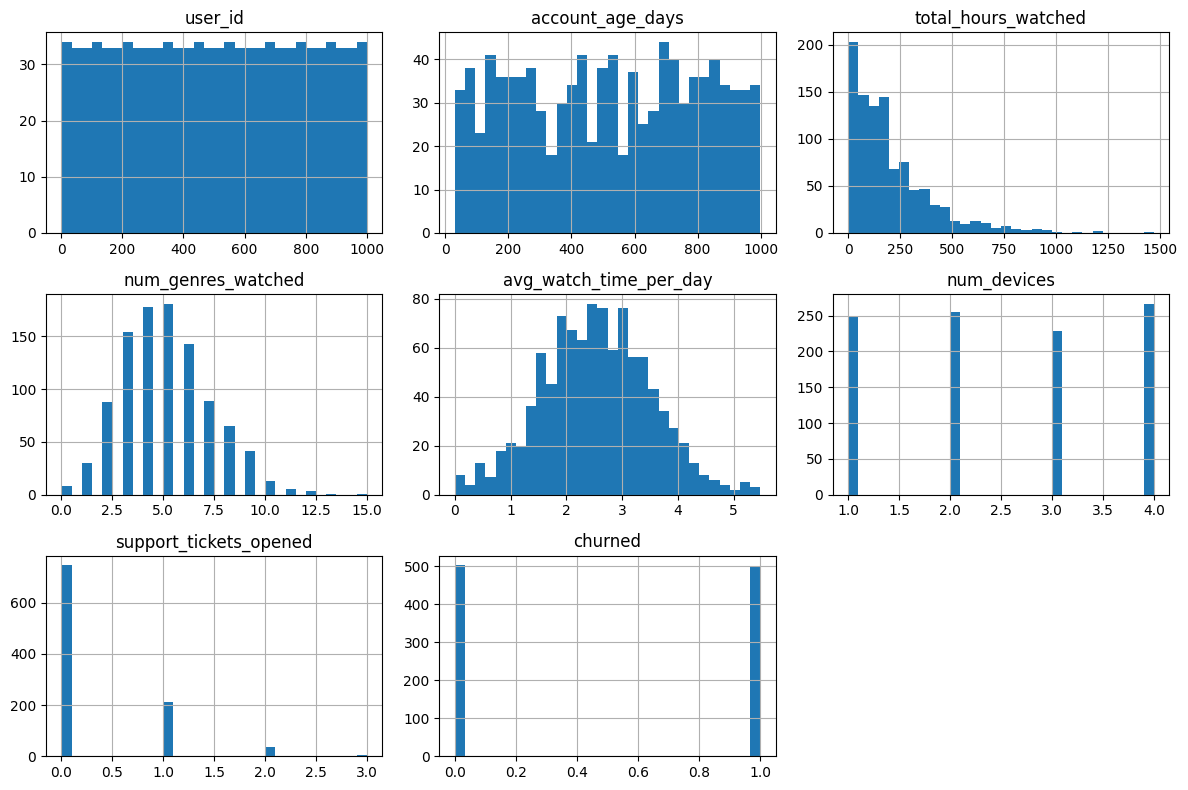

In [20]:
# numerical columns
df.hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

In [21]:
                        # My Theories.
# ----------------------------------------------------------------------
# Users with older accounts and declining engagement — measured by both daily watch time and total hours watched — appear more likely to churn.
# Contrary to expectation, users who open more support tickets are less likely to churn — possibly indicating that users who seek help are more 
# engaged or that support effectively resolves churn-risk issues.
# It appears there’s no strong correlation between churn and number of devices — unless maybe one device is the main one and it’s in another household.
# A decrease in average watch time correlates with fewer genres watched — which aligns with the earlier insight that older users are less engaged and 
# more likely to churn.
# Users with older accounts tend to explore fewer genres and watch less on average per day — all indicators of declining engagement, which appears to 
# strongly correlate with churn risk.

In [22]:
# Define engagement levels
df['engagement_level'] = pd.cut(df['avg_watch_time_per_day'], bins=[0, 1, 2, 3, 10], labels=["Low", "Med", "High", "Very High"])
print(df)

# Group and calculate churn rate
churn_rates = df.groupby('engagement_level', observed=True)['churned'].mean()

# Format as percentage with 2 decimal places
churn_rates_percent = churn_rates.apply(lambda x: f"{x * 100:.2f}%")

# Display the formatted churn rates
print(churn_rates_percent)


     user_id  account_age_days  total_hours_watched  num_genres_watched  \
0          1               132                    2                   7   
1          2               465                   15                   5   
2          3               890                  235                   4   
3          4               300                  152                   4   
4          5               136                  277                   6   
..       ...               ...                  ...                 ...   
995      996               639                   43                   4   
996      997               134                   36                   4   
997      998               128                  192                   4   
998      999               540                  148                   4   
999     1000               414                  221                   6   

     avg_watch_time_per_day  num_devices  support_tickets_opened  churned  \
0                  2.2

In [26]:
#                       Checking My Theories                         
#---------------------------------------------------------------------------
# checking for corrolation between avg watch times and num of genres watched
correlation = df['avg_watch_time_per_day'].corr(df['num_genres_watched'])
print(f"Correlation between watch time per day and genres watched: {correlation:.2f}") # no real corrolation here.

correlation = df['total_hours_watched'].corr(df['num_genres_watched'])
print(f"Correlation between total hours watched and genres watched: {correlation:.2f}") # no real corrolation here.

# checking for corrolation between support tickets and churned users.
correlation = df['support_tickets_opened'].corr(df['churned'])
print(f"Correlation between support tickets opened and churn: {correlation:.2f}") # no real corrolation here.

# checking for corrolation between account age in days and churned users
corr = df['account_age_days'].corr(df['churned'])
print(f"Correlation between account age and churn: {corr:.2f}")

Correlation between watch time per day and genres watched: -0.03
Correlation between total hours watched and genres watched: -0.03
Correlation between support tickets opened and churn: -0.01
Correlation between account age and churn: -0.00


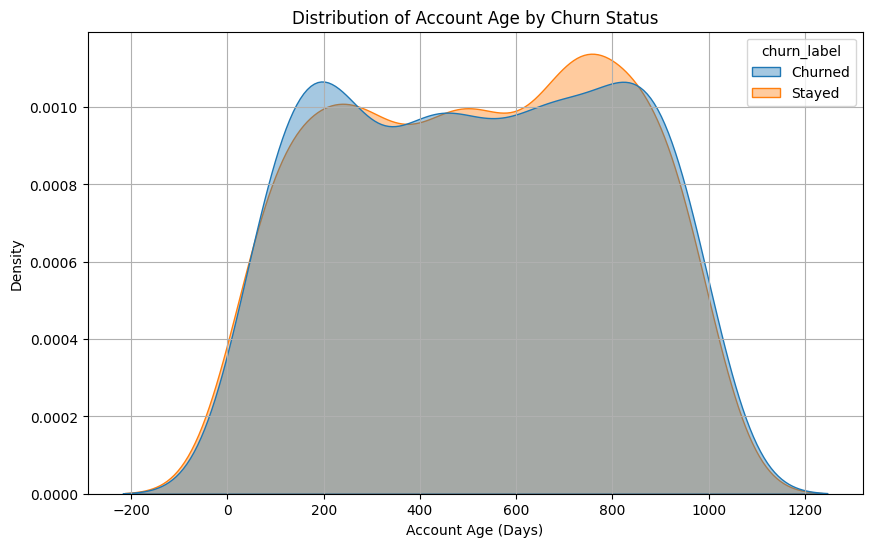

In [27]:
# Create a new column to make the churn values more readable
df['churn_label'] = df['churned'].map({0: 'Stayed', 1: 'Churned'})

# Plot distributions of account age for churned vs non-churned users
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='account_age_days', hue='churn_label', fill=True, common_norm=False, alpha=0.4)
plt.title("Distribution of Account Age by Churn Status")
plt.xlabel("Account Age (Days)")
plt.ylabel("Density")
plt.grid(True)
plt.show()


In [ ]:
# users to increasingly churn at the 200 day mark, although as they stay longer there is a decrease in churnes users

In [30]:
# predicting why users churn at 200 day mark
df_around_200 = df[(df['account_age_days'] >= 150) & (df['account_age_days'] <= 250)]
print(df_around_200)

     user_id  account_age_days  total_hours_watched  num_genres_watched  \
9         10               151                   94                   5   
11        12               244                   45                   8   
19        20               160                    4                   5   
28        29               221                  178                   3   
31        32               190                  307                   4   
..       ...               ...                  ...                 ...   
949      950               174                  463                   3   
950      951               230                  420                   5   
980      981               175                  129                   6   
983      984               206                  274                   8   
988      989               246                  454                   4   

     avg_watch_time_per_day  num_devices  support_tickets_opened  churned  \
9                  2.1

In [ ]:
# highly engaged users seem to churn.
# possibly users are binge watching? 
# two users opened support tickets and churned but there are others who opened support tickets and didnt churn

In [31]:
# Filter users who churned within 150–250 day period
churned_around_200 = df_around_200[df_around_200['churned'] == 1]

# Look at the distribution of genres watched
genre_stats = churned_around_200['num_genres_watched'].describe()
genre_counts = churned_around_200['num_genres_watched'].value_counts().sort_index()

print("Summary statistics for genres watched by churned users (150–250 days):")
print(genre_stats)

print("\nDistribution of genre counts:")
print(genre_counts)


Summary statistics for genres watched by churned users (150–250 days):
count    61.00000
mean      5.00000
std       2.12132
min       1.00000
25%       3.00000
50%       5.00000
75%       7.00000
max      10.00000
Name: num_genres_watched, dtype: float64

Distribution of genre counts:
num_genres_watched
1      1
2      5
3     13
4      9
5      9
6      7
7      7
8      8
9      1
10     1
Name: count, dtype: int64


In [ ]:
# seems users with a lower genre watch count churn.